# Moneyball - Baseball Dataset

URL: https://www.openml.org/d/41021

## Content

1) [Data preprocessing](#dataproc)

2) [Model training](#train)
    
2.a) [Linear regression](#linear)

2.b) [Lasso Regression](#lasso)

2.c) [Random Forest](#rf)

2.d) [kNN](#knn)

3) Evaluation

---

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# models for linear regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# models for Lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# statistic tools
from sklearn import metrics
from statistics import stdev

# preprocessing
from sklearn import preprocessing

---

<a id='dataproc'></a>

# 1) Data preprocessing

In [2]:
input_file = 'Moneyball.csv'
df_raw = pd.read_csv(input_file,  sep = ',', header = 0)
df_raw

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,?,?,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4,5,162,0.306,0.37799999999999995
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5,4,162,0.315,0.40299999999999997
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,?,?,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,?,?,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,?,?,161,?,?
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,?,?,161,?,?
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,1,2,165,?,?
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,?,?,163,?,?


# Description of data columns

RS ... Runs Scored, 

RA ... Runs Allowed

***RD ... Run differential (actually difference)***

W ... Wins

OBP ... On-Base Percentage

SLG ... Slugging Percentage

BA ... Batting Average

Playoffs (binary)

RankSeason

RankPlayoffs

G ... Games Played

OOBP ... Opponent On-Base Percentage

OSLG ... Opponent Slugging Percentage

In [3]:
col_dict = {'RS':  'Runs Scored', 
            'RA':  'Runs Allowed',
            'RD':  'Run differential (actually difference)',
            'W':  'Wins',
            'OBP':  'On-Base Percentage',
            'SLG':  'Slugging Percentage',
            'BA':  'Batting Average',
            'Playoffs': 'playoffs reached (binary)',
            'RankSeason': 'season rank',
            'RankPlayoffs': 'playoff rank',
            'G':  'Games Played',
            'OOBP':  'Opponent On-Base Percentage',
            'OSLG':  'Opponent Slugging Percentage'
           }

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
            
def add_RD(df):
    df['RD'] = df.apply(lambda row: row.RS - row.RA, axis = 1) 

# First look on DATA and information

In [5]:
display_all(df_raw.tail().transpose())
print('#'*40)
display('Some more info')
print('#'*40)
display(df_raw.info())

,1227,1228,1229,1230,1231
Team,PHI,PIT,SFG,STL,WSA
League,NL,NL,NL,NL,AL
Year,1962,1962,1962,1962,1962
RS,705,706,878,774,599
RA,759,626,690,664,716
W,81,93,103,84,60
OBP,0.33,0.321,0.341,0.335,0.308
SLG,0.39,0.394,0.441,0.394,0.373
BA,0.26,0.268,0.278,0.271,0.25
Playoffs,0,0,1,0,0


########################################


'Some more info'

########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    1232 non-null   object 
 11  RankPlayoffs  1232 non-null   object 
 12  G             1232 non-null   int64  
 13  OOBP          1232 non-null   object 
 14  OSLG          1232 non-null   object 
dtypes: float64(3), int64(6), object(6)
memory usage: 144.5+ KB


None

# Preprocessing for random forest

In [6]:
# Split into train and test
def split_simple(df, n): 
    '''n... number to split at'''
    return df[:n].copy(), df[n:].copy()

In [7]:
df_prep = df_raw
add_RD(df_prep) # add Round Difference
display_all(df_prep.tail().transpose())
display(df_prep.info())

,1227,1228,1229,1230,1231
Team,PHI,PIT,SFG,STL,WSA
League,NL,NL,NL,NL,AL
Year,1962,1962,1962,1962,1962
RS,705,706,878,774,599
RA,759,626,690,664,716
W,81,93,103,84,60
OBP,0.33,0.321,0.341,0.335,0.308
SLG,0.39,0.394,0.441,0.394,0.373
BA,0.26,0.268,0.278,0.271,0.25
Playoffs,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    1232 non-null   object 
 11  RankPlayoffs  1232 non-null   object 
 12  G             1232 non-null   int64  
 13  OOBP          1232 non-null   object 
 14  OSLG          1232 non-null   object 
 15  RD            1232 non-null   int64  
dtypes: float64(3), int64(7), object(6)
memory usage: 154.1+ KB


None

In [8]:
cols_to_drop = ['Team', 'League', 'Year', 'RankSeason', 'RankPlayoffs', 'Playoffs']
df_prep = df_prep.drop(cols_to_drop, axis=1)

# Fix missing values and type
df_prep.replace("?",0, inplace=True)
#df_prep = df_prep[df_prep.OOBP != 0]
df_prep[['OOBP','OSLG']] = df_prep[['OOBP','OSLG']].astype(float)

In [9]:
display(df_prep.columns.values)
display(df_prep.index)

array(['RS', 'RA', 'W', 'OBP', 'SLG', 'BA', 'G', 'OOBP', 'OSLG', 'RD'],
      dtype=object)

RangeIndex(start=0, stop=1232, step=1)

In [10]:
display(df_prep)

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG,RD
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415,46
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378,100
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403,7
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428,-72
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424,-146
...,...,...,...,...,...,...,...,...,...,...
1227,705,759,81,0.330,0.390,0.260,161,0.000,0.000,-54
1228,706,626,93,0.321,0.394,0.268,161,0.000,0.000,80
1229,878,690,103,0.341,0.441,0.278,165,0.000,0.000,188
1230,774,664,84,0.335,0.394,0.271,163,0.000,0.000,110


In [11]:
df_rf = df_prep

# Bootstrapping:

Bootstrapping: Selecting data from a data to generate a new dataset of the same size by picking WITH replacement.

Example:

    > DS = [1,2,3,4]
    > could turn into 
    > DS_bootstrapped = [3,2,4,4]
    
Consequences:

- Instances (rows) of the original set can end up duplicated (multiple times) in the resulting dataset.
- Some instances are left out entirely (up to 1/3) --> "Out-Of-Bag Dataset" (=OOB Dataset)

## Using the OOB Dataset

The OOB dataset was not used to construct the tree, so we can actually use it to test our tree and gain some insight into the error measure of the tree.
This error is called the "Out-Of-Bag Error" (OOB error).

# Preprocessing LinReg

<Figure size 432x288 with 0 Axes>

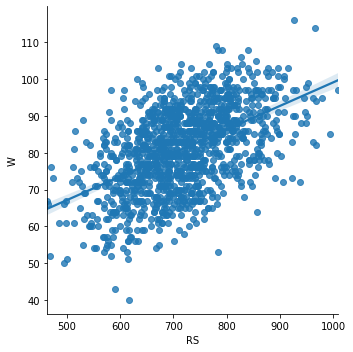

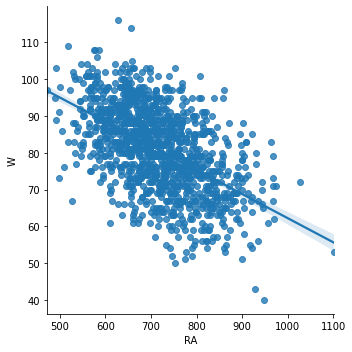

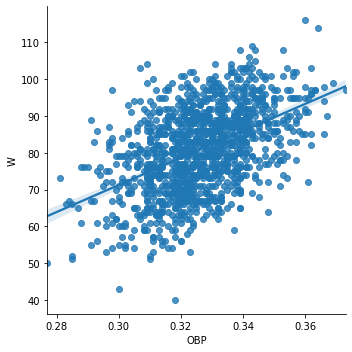

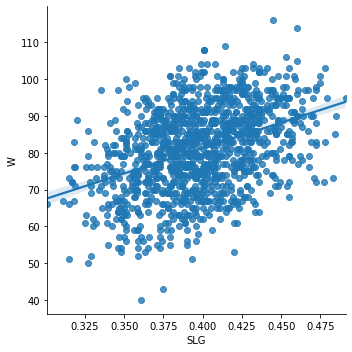

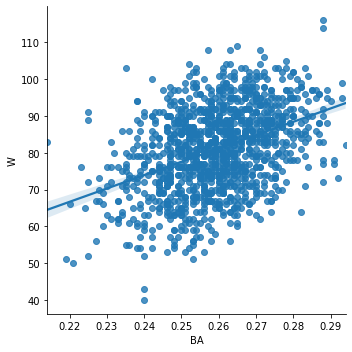

In [12]:
plt.figure()
sns.lmplot("RS","W",df_prep)

sns.lmplot("RA","W",df_prep)

sns.lmplot("OBP","W",df_prep)

sns.lmplot("SLG","W",df_prep)

sns.lmplot("BA","W",df_prep)
df_lin = df_prep


# Preprocessing LassoReg

# Preprocessing kNN

In [13]:
from sklearn.impute import SimpleImputer

df_knn = df_raw

from sklearn.impute import SimpleImputer

imputerQ1 = SimpleImputer(missing_values='?', strategy='constant', fill_value=0.3)
imputerQ1 = imputerQ1.fit(df_knn[['OOBP', 'OSLG']])
df_knn[['OOBP', 'OSLG']] = imputerQ1.transform(df_knn[['OOBP', 'OSLG']])

imputerQ2 = SimpleImputer(missing_values='?', strategy='constant', fill_value=6)
imputerQ2 = imputerQ2.fit(df_knn[['RankSeason']])
df_knn[['RankSeason']] = imputerQ2.transform(df_knn[['RankSeason']])
df_knn.League.replace(['NL', 'AL'], [1, 0], inplace=True)

#Drop useless columns - of no interest
df_knn.drop(['RankPlayoffs', 'Team', 'Year'], axis=1, inplace=True)


In [14]:

display(df_knn)

,League,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,G,OOBP,OSLG,RD
0,1,734,688,81,0.328,0.418,0.259,0,6,162,0.317,0.415,46
1,1,700,600,94,0.320,0.389,0.247,1,4,162,0.306,0.37799999999999995,100
2,0,712,705,93,0.311,0.417,0.247,1,5,162,0.315,0.40299999999999997,7
3,0,734,806,69,0.315,0.415,0.260,0,6,162,0.331,0.428,-72
4,1,613,759,61,0.302,0.378,0.240,0,6,162,0.335,0.424,-146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1,705,759,81,0.330,0.390,0.260,0,6,161,0.3,0.3,-54
1228,1,706,626,93,0.321,0.394,0.268,0,6,161,0.3,0.3,80
1229,1,878,690,103,0.341,0.441,0.278,1,1,165,0.3,0.3,188
1230,1,774,664,84,0.335,0.394,0.271,0,6,163,0.3,0.3,110


<a id='train'></a>

# 2) Model training
---

<a id='linear'></a>

# a) Linear Regression

In [15]:
Y = df_lin[['W']]
X = df_lin[['RS','RA','OBP','SLG','BA']]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

In [16]:
linreg = LinearRegression(normalize = True)
linreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [17]:
linreg.coef_
score = linreg.score(X_test,Y_test)
print("score: ",score)
Y_lin_pred = linreg.predict(X_train)

score:  0.8877439871498782


<a id='lasso'></a>

# b) Lasso Regression

In [18]:
lasso = Lasso(normalize = True)
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor = GridSearchCV(lasso,parameters,scoring = 'neg_mean_squared_error',cv = 5)

In [19]:
lasso_regressor.fit(X_train,Y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 1e-08}
-16.438253222102006


<a id='knn'></a>

In [20]:
Y_lasso_pred = lasso_regressor.predict(X_test)

# c) kNN

In [21]:
train_knn, test_knn = train_test_split(df_knn, test_size=0.3)

x_train_knn = train_knn.drop('W', axis=1)
y_train_knn = train_knn['W']

x_test_knn = test_knn.drop('W', axis=1)
y_test_knn = test_knn['W']


In [22]:
#Scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

x_train_knn_scaled = scaler.fit_transform(x_train_knn)
x_train_knn = pd.DataFrame(x_train_knn_scaled)

x_test_knn_scaled = scaler.fit_transform(x_test_knn)
x_test_knn = pd.DataFrame(x_test_knn_scaled)

In [23]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

<a id='rf'></a>

In [24]:
rmse_val_knn = [] # to store rmse values for different k
for k in range(15):
    k = k + 1
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(x_train_knn, y_train_knn)
    pred = model.predict(x_test_knn)
    error = sqrt(mean_squared_error(y_test_knn, pred))
    rmse_val_knn.append(error)
    print("RMSE for k={}: {}".format(k, error))
    print("R^2 for k={}: {}\n".format(k, model.score(x_test_knn, y_test_knn)))

RMSE for k=1: 5.663061916513916
R^2 for k=1: 0.7611622961281367

RMSE for k=2: 4.9658972135088675
R^2 for k=2: 0.8163479757666569

RMSE for k=3: 4.758144590062384
R^2 for k=3: 0.831393024583744

RMSE for k=4: 4.5225224664405435
R^2 for k=4: 0.8476783156817965

RMSE for k=5: 4.406776109093322
R^2 for k=5: 0.8553753769697942

RMSE for k=6: 4.262563130845624
R^2 for k=6: 0.864686254429189

RMSE for k=7: 4.219004621945797
R^2 for k=7: 0.8674376270267915

RMSE for k=8: 4.203491550629812
R^2 for k=8: 0.8684106853654529

RMSE for k=9: 4.19141996639182
R^2 for k=9: 0.8691653963303323

RMSE for k=10: 4.218786811651208
R^2 for k=10: 0.8674513140012254

RMSE for k=11: 4.227134023245564
R^2 for k=11: 0.8669262784680911

RMSE for k=12: 4.229590190926679
R^2 for k=12: 0.8667715891062684

RMSE for k=13: 4.303959624246651
R^2 for k=13: 0.8620452544678806

RMSE for k=14: 4.31383310929739
R^2 for k=14: 0.8614115791592774

RMSE for k=15: 4.376476842112791
R^2 for k=15: 0.857357304542235



Text(0, 0.5, 'RMSE')

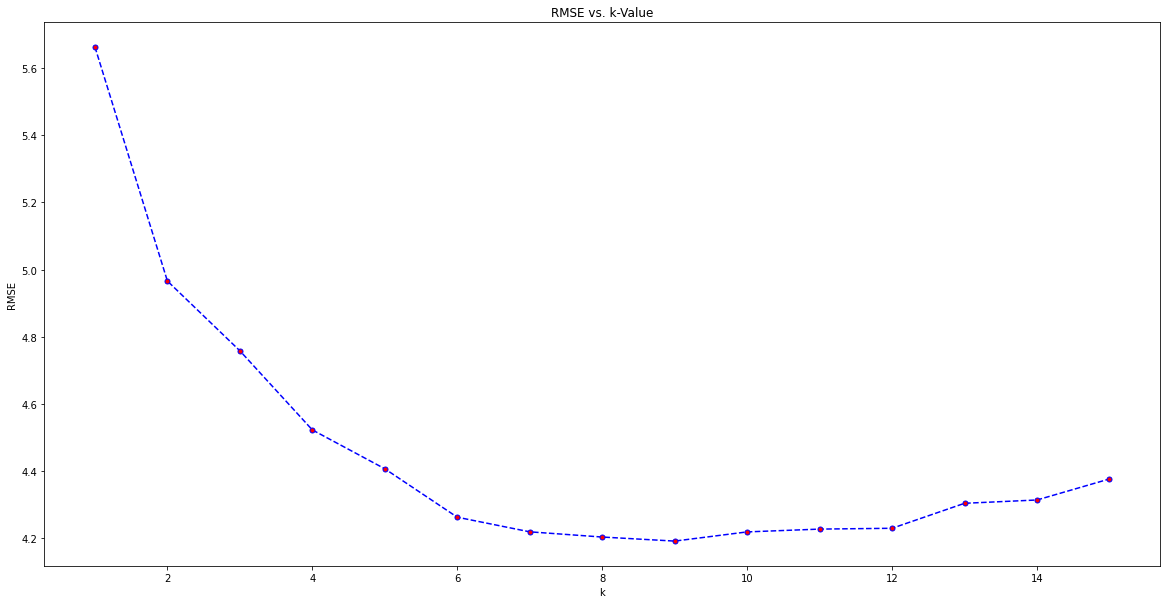

In [25]:
plt.figure(figsize=(20,10))
plt.plot(range(1,16), rmse_val_knn, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=5)
plt.title('RMSE vs. k-Value')
plt.xlabel('k')
plt.ylabel('RMSE')

## Optimizing kNN-search for optimal k-Value via Gridsearch

In [26]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, 25)}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=100)
model.fit(x_train_knn, y_train_knn)
print("Best k-Value is: ", model.best_params_['n_neighbors'])

Best k-Value is:  8


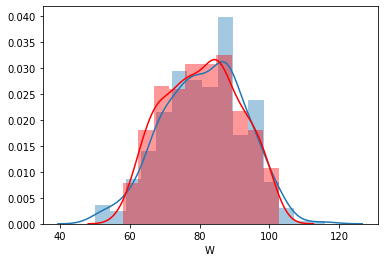

In [27]:
model_cv = neighbors.KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
model_cv.fit(x_train_knn, y_train_knn)
pred_cv = model.predict(x_test_knn)
sns.distplot(y_test_knn)
sns.distplot(pred_cv, color='red')


# d) Random Forest

In [28]:
# Imports for RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from IPython.display import display

In [29]:
import math
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train, X_valid, y_train, y_valid, score='neg_mean_squared_error'):
    res = {
        'RMS(train)': rmse(m.predict(X_train), y_train),
        'RMS(valid)': rmse(m.predict(X_valid), y_valid)}
    if score=='neg_mean_squared_error':
        res['Model_Score=r²'] = [np.sqrt(-m.score(X_train, y_train)), np.sqrt(-m.score(X_valid, y_valid))]
    elif score=='pos_mean_squared_error':
        res['Model_Score=r²'] = [np.sqrt(m.score(X_train, y_train)), np.sqrt(m.score(X_valid, y_valid))]
    else:
        res['Model_Score=r²'] = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res['oob_score_'] = m.oob_score_
    display(res)
    return res

# Feature importance
from prettytable import PrettyTable as PT # pip install PTable
def print_RF_featureImportance(rf, X):
    table = PT()
    table.field_names = ['Feature', 'Score', 'Comment']
    for name, score in zip(X.columns.values, rf.feature_importances_):
        print(f"{name}: {score:.5f}\t\t... {col_dict[name]}")
        table.add_row([name, round(score, ndigits=4), col_dict[name]])
    print(table)

def print_GridSearchResult(grid):
    print(grid.best_params_)
    print(grid.best_estimator_)

In [30]:
# Split for random forest
df = df_rf
rnd_state = 42
ratio = 0.2 # test/num_samples
#####
num_instances, _ = df.shape
print(f"From {num_instances} using {num_instances*ratio:.0f} for testing and {num_instances*(1-ratio):.0f} for training. Ratio = {ratio*100:.2f}%")
X, y = (df.drop(['W', 'RD'], axis=1), df.W)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ratio, random_state = rnd_state)
display(X_test)

From 1232 using 246 for testing and 986 for training. Ratio = 20.00%


,RS,RA,OBP,SLG,BA,G,OOBP,OSLG
549,599,653,0.310,0.342,0.235,162,0.000,0.000
1050,775,681,0.336,0.436,0.270,162,0.000,0.000
244,949,768,0.360,0.472,0.282,162,0.318,0.408
553,693,595,0.324,0.381,0.255,162,0.000,0.000
1165,495,752,0.277,0.327,0.221,164,0.000,0.000
...,...,...,...,...,...,...,...,...
88,755,728,0.312,0.454,0.248,162,0.326,0.405
634,699,600,0.316,0.390,0.250,162,0.000,0.000
298,826,969,0.330,0.454,0.266,162,0.360,0.473
376,748,880,0.337,0.407,0.270,162,0.347,0.466


In [31]:
before = 0

In [32]:
# Simple training of RFRegressor
n_cores = 4
rf_W = RandomForestRegressor(n_jobs=n_cores)
# The following code is supposed to fail due to string values in the input data
rf_W.fit(X_train, y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf_W, X_train, X_test, y_train, y_test)


Before:


0

Now:


/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


{'RMS(train)': 1.6463123843927905,
 'RMS(valid)': 4.178070908711176,
 'Model_Score=r²': [nan, nan]}

In [33]:
print_RF_featureImportance(rf_W, X_train)

RS: 0.44458		... Runs Scored
RA: 0.43456		... Runs Allowed
OBP: 0.05705		... On-Base Percentage
SLG: 0.02348		... Slugging Percentage
BA: 0.01928		... Batting Average
G: 0.00464		... Games Played
OOBP: 0.00895		... Opponent On-Base Percentage
OSLG: 0.00746		... Opponent Slugging Percentage
+---------+--------+------------------------------+
| Feature | Score  |           Comment            |
+---------+--------+------------------------------+
|    RS   | 0.4446 |         Runs Scored          |
|    RA   | 0.4346 |         Runs Allowed         |
|   OBP   | 0.057  |      On-Base Percentage      |
|   SLG   | 0.0235 |     Slugging Percentage      |
|    BA   | 0.0193 |       Batting Average        |
|    G    | 0.0046 |         Games Played         |
|   OOBP  | 0.009  | Opponent On-Base Percentage  |
|   OSLG  | 0.0075 | Opponent Slugging Percentage |
+---------+--------+------------------------------+


In [34]:
rf_W_prediction = rf_W.predict(X_test)

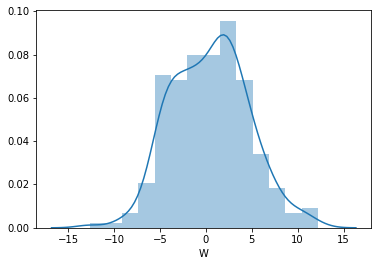

In [35]:
sns.distplot(y_test-rf_W_prediction)

In [36]:
n_cores = 4
number_of_trees = 1000 # default = 100
rf = RandomForestRegressor(n_jobs=n_cores, n_estimators=number_of_trees, bootstrap=True) #, verbose=1)

rf.fit(X_train, y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf, X_train, X_test, y_train, y_test)
print()
print("Feature importance")
print_RF_featureImportance(rf, X_train)
rf_RD = rf

Before:


{'RMS(train)': 1.6463123843927905,
 'RMS(valid)': 4.178070908711176,
 'Model_Score=r²': [nan, nan]}

Now:


/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


{'RMS(train)': 1.6148491438398838,
 'RMS(valid)': 4.1413632507785145,
 'Model_Score=r²': [nan, nan]}


Feature importance
RS: 0.44046		... Runs Scored
RA: 0.43817		... Runs Allowed
OBP: 0.05520		... On-Base Percentage
SLG: 0.02511		... Slugging Percentage
BA: 0.01930		... Batting Average
G: 0.00465		... Games Played
OOBP: 0.00999		... Opponent On-Base Percentage
OSLG: 0.00712		... Opponent Slugging Percentage
+---------+--------+------------------------------+
| Feature | Score  |           Comment            |
+---------+--------+------------------------------+
|    RS   | 0.4405 |         Runs Scored          |
|    RA   | 0.4382 |         Runs Allowed         |
|   OBP   | 0.0552 |      On-Base Percentage      |
|   SLG   | 0.0251 |     Slugging Percentage      |
|    BA   | 0.0193 |       Batting Average        |
|    G    | 0.0047 |         Games Played         |
|   OOBP  |  0.01  | Opponent On-Base Percentage  |
|   OSLG  | 0.0071 | Opponent Slugging Percentage |
+---------+--------+------------------------------+


In [37]:
rfRD_prediction = rf_RD.predict(X_test)

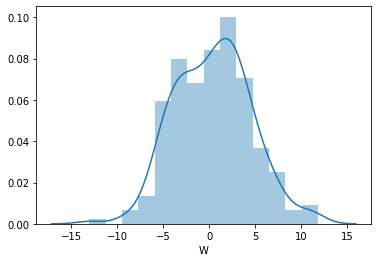

In [38]:
sns.distplot(y_test-rfRD_prediction)

# Optimize Hyperparameters via GridSearch

because we lazy bois

## Notes on the RandomForestRegressor from scikit-learn
-----
The default values for the parameters controlling the size of the trees
(e.g. ``max_depth``, ``min_samples_leaf``, etc.) lead to fully grown and
unpruned trees which can potentially be very large on some data sets. To
reduce memory consumption, the complexity and size of the trees should be
controlled by setting those parameter values.

## Number of variables/features per tree --> 'max_features'

A good starting point is/might be: *the square root of the number of features presented to the tree*. Then, test some values below and above that starting point.

## Number of trees in the forest --> 'n_estimators'

The more the merrier

In [39]:
from numpy import sqrt
num_features = X.shape[1]
print(num_features)
sqrt_num_features = round(sqrt(num_features), 0)
sqrt_num_features

8


3.0

In [40]:
from sklearn.model_selection import GridSearchCV
n_cores = 4
# but since we dont have that many features...we are just gonna brute force it :D
param_grid = [
    {
        'n_estimators': [3, 10, 30, 100, 1000], 'max_features': [i for i in range(1,num_features+1)]
    }
#,{'bootstrap': [False], 'n_estimators': [3, 30, 100, 1000], 'max_features': [2, 3, 4]},
]
k = 10
forest_reg = RandomForestRegressor(n_jobs=n_cores)
grid_search = GridSearchCV(forest_reg, param_grid, n_jobs=n_cores , cv=k, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=4,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [41]:
print_GridSearchResult(grid_search)
grid_search.scorer_()
scores = grid_search.score(X_test, y_test)
print_score(grid_search, X_train, X_test, y_train, y_test)

{'max_features': 6, 'n_estimators': 1000}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


TypeError: __call__() missing 3 required positional arguments: 'estimator', 'X', and 'y_true'

# k-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable

def display_scores(scores):
    print("Scores:", scores)
    table = PrettyTable()
    table.field_names = ['Run', 'Score']
    for i, score in enumerate(scores):
        table.add_row([i, round(score, 3)])
    print(table)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
k = 5
model = rf_RD
scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k)

In [ ]:
display_scores(rf_rmse_scores)

<a id='eval'></a>

# 3) Evaluation

# a) Linear Regression

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_train, Y_lin_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_train, Y_lin_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_train, Y_lin_pred)))

In [ ]:
sns.distplot(Y_train)
sns.distplot(Y_lin_pred)

# b) Lasso Regression

In [ ]:
sns.distplot(Y_train)
sns.distplot(Y_lasso_pred)

In [ ]:
# geht leider noch nicht die dimesionen passen nicht zusammen
#print('Mean Absolute Error:', metrics.mean_absolute_error(Y_train, Y_lasso_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(Y_train, Y_lasso_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_train, Y_lasso_pred)))

# c) k-Nearest Neighbors

# Save model and DF

In [ ]:
# Dump model
import joblib
import os

os.makedirs('tmp', exist_ok=True)
joblib.dump(rf_RD, "tmp/rf_RD.pkl")
# To load the model
# my_model_loaded = joblib.load("my_model.pkl")

In [ ]:
import os
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')
df_raw = pd.read_feather('tmp/raw')